<h1> Titanic Kaggle Competition</h1>



## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# for analysing the data
import numpy as np
import pandas as pd
import random as rand

# for visualizing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ML Algorithms
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


## Acquire Data

We will use Pandas to store our data.

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TitannicKaggle/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TitannicKaggle/test.csv')
combine = [train_df, test_df] # combine to perform some operations on both datasets

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.info()
print('-'*45)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

## Analyze by pivoting

In **Pclass** we observe great correlation (>0.5) among Pclass=1 and Survived.

Sex=Female had a high survival rate at 74%

In [7]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [8]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


## Analyze by visualization of data

Create a histogram depicting the survivors based on the age.

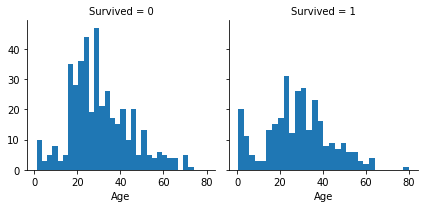

In [9]:
graph = sns.FacetGrid(train_df, col='Survived')
graph.map(plt.hist, 'Age', bins=30)

We can see that:

*   Childern with than 4 years of age had high survival rate
*   Some old passengers(Age=80) survived
* Most passengers in the age of 15-35 did not survive
* Most passengers are in 15-35 age range



Histograms based on Pclass

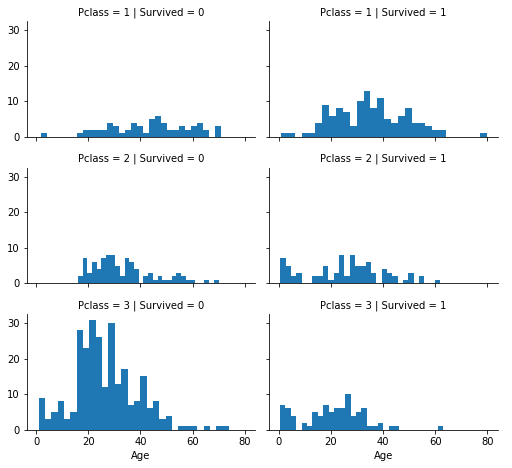

In [10]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height= 2.2, aspect= 1.6)
grid.map(plt.hist, 'Age', bins= 30)
grid.add_legend()

We can see that:

*  Most passengers of Pclass=1 survived 
*  Pclass=3 had the most most passengers, but most of them did not survive
* Infant passengers in Pclass=2 and Pclass=3 mostly survived.



## Correcting Data

### By dropping features

Cabin and Ticket can be dropped as they do not greatly help us.**bold text**

In [11]:
print('Before drop', train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis= 1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis= 1)
combine = [train_df, test_df]
print('After drop', train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)


Before drop (891, 12) (418, 11) (891, 12) (418, 11)
After drop (891, 10) (418, 9) (891, 10) (418, 9)


### Creating new features extracting  from existing

We will extract all the Titles using the (\w+\.) Regex pattern, which matches the first word which ends with a dot character within Name feature.

In [12]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Now we will replace titles with a more common name or we will classify them as "Rare"

In [13]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Now we will convert categorial titles to numeric

In [14]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


It is now safe to drop the "Name" feature from both datasets, as well as the PassengerId feature in the training dataset.

In [15]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### Converting categorial feature

We will convert the Sex feature to a new named Gender where female=1 and male=0

In [16]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


### Completing numerical feature

First we will complete missing values or null types on "Age". An accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

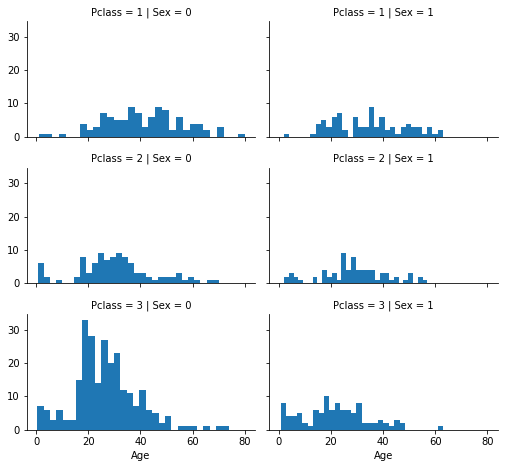

In [17]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', bins=30)
grid.add_legend()

First we will create an  empty array to contain guessed Age values based on Pclass x Gender combos.

In [18]:
guess_ages = np.zeros((2,3))
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_df.median()
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()   

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Now we will create age ranges and correalte them with Survived

In [19]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


We will replace age with ordinals on these bands

In [20]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### Create new feature combining existing ones

We will create a new feature "FamilySize" which combines Parch and SibSp. This way we can drop Parch and SibSp from our datasets.

In [21]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Now we can create another feature "IsAlone"

In [22]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


We will now drop Parch, SibSp and FamilySize in favour of IsAlone

In [23]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


Another feature we can create is the combination of "Age" and "Pclass"

In [24]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature

We will fill "Embarked" feature missing values with the most common occurance

In [25]:
freq = train_df.Embarked.dropna().mode()[0]
freq

'S'

In [26]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


Now we will convert "Embark" feature to numeric

In [27]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### Completing and converting numeric feature

We will complete missing values on "Fare" in test dataset with feature with the value that occurs most frequently

In [28]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


Now we can create "FareBand", a range for the "Fare" values

In [29]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [30]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


## Models

We will now train a model in order to predict the solution. Various models will be used

In [31]:
X_train = train_df.drop('Survived', axis= 1)
Y_train = train_df['Survived']
X_test = test_df.drop('PassengerId', axis= 1).copy()


In [32]:
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

### Logistic Regression

In [50]:
lr_model = LogisticRegression()
lr_model.fit(X_train, Y_train)
Y_pred = lr_model.predict(X_test)
lr_final = round(lr_model.score(X_train, Y_train)*100,2)
print("Logistic Regression score: ", lr_final)

Logistic Regression score:  80.36


### Support Vector Machines

first we try SVC

In [51]:
model = SVC()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
svc_final = round(model.score(X_train, Y_train)*100,2)
print("SVM score: ", svc_final)

SVM score:  78.23


Now we will try Linear SVC to see if we can get better results.

In [52]:
model = LinearSVC()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
lsvc_final = round(model.score(X_train, Y_train)*100,2)
print("SVM score: ", lsvc_final)

SVM score:  79.12


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We can see a small improvement in the model's score.

In SVM we can "play" with the model's parameters in order to achieve higher score.

### KNN

In [53]:
model = KNeighborsClassifier(n_neighbors= 3)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
knn_final = round(model.score(X_train, Y_train)*100,2)
print("KNN score: ", knn_final)

KNN score:  84.74


### Gaussian Naive Bayes

In [55]:
model = GaussianNB()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
gnb_final = round(model.score(X_train, Y_train)*100,2)
print("GaussianNB score: ", gnb_final)

GaussianNB score:  72.28


From this model we get the lowest score so far.

### Perceptron

In [56]:
model = Perceptron()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
p_final = round(model.score(X_train, Y_train)*100,2)
print("Perceptron score: ", p_final)

Perceptron score:  78.34


## Stochastic Gradient Descent

In [65]:
model = SGDClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
sgd_final = round(model.score(X_train, Y_train)*100,2)
print("SGD score: ", sgd_final)

SGD score:  78.11


### Decision Tree

In [66]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
dt_final = round(model.score(X_train, Y_train)*100,2)
print("SVM score: ", dt_final)

SVM score:  86.76


### Random Forest

In [67]:
model = RandomForestClassifier(n_estimators= 100)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
rf_final = round(model.score(X_train, Y_train)*100,2)
print("SVM score: ", rf_final)

SVM score:  86.76


## Evaluation of the Model

We will rank our models in order to select the best one.

In [68]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [svc_final, knn_final, lr_final, 
              rf_final, gnb_final, p_final, 
              sgd_final, lsvc_final, dt_final]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
8,Decision Tree,86.76
1,KNN,84.74
2,Logistic Regression,80.36
7,Linear SVC,79.12
5,Perceptron,78.34
0,Support Vector Machines,78.23
6,Stochastic Gradient Decent,78.11
4,Naive Bayes,72.28


Both Random Forest and Decision Tree score the same, but we'll chose Random forest as the best since it doesn't have decision tree's habit of overfitting to their training set.

This solution is based on Manav Sehgal's solution.